# DATA VISUALISATION
If not present , create locally a 'Data' folder containing the datasets<br>

## Load Data

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# Formatting; affects not only seaborn but also plt!
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":10,"axes.titlesize":18,"axes.labelsize":10})
cmap_cubehelix =sns.diverging_palette(220, 20, n=7)
sns.set_palette(cmap_cubehelix)

# environment settings
data_path = "Data/"

In [30]:
train_path = data_path + "train.csv"
df = pd.read_csv(train_path, dtype={
    'PassengerId': str,
    'Survived': bool,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings / spouses aboard
    'Parch': 'uint8', # number of parents / children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'}) # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

# serialize dataframe for later use in preprocessing notebook
filehandler = open((data_path+"train_dv.obj").encode('UTF-8'),"wb")
pickle.dump(df, filehandler)
filehandler.close()

## View Data

In [31]:
#view the data
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,False,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,False,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,False,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,True,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,True,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Assumptions and considerations about the available 12 fields:
* *PassengerId*, *Ticket*: unlikely to be useful because they can be considered as some sort of ids
* *Name*: unlikely to be useful because can be considered as some sort of id, but surname could be useful because of family relationships among the passengers
* *Pclass*: can be useful because it locates people on the ship based on the class fare
* *sex*: can be useful because of priorities for lifeboat rescue (female first)
* *age*: can be useful because of priorities for lifeboat rescue (young and elder first), adult are stronger than others and more likely to survive
* *SibSp*, Parch: can be useful because relatives are likely to help each others
* *Fare*: unlikely to be useful because its meaning it's likely to be included in 'Pclass'
* *Cabin*: can be useful in relation of where are the cabins are positioned on the ship
* *Embarked*: unlikely to be useful because all listed embark happened before the disaster

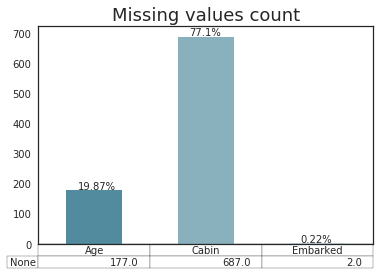

In [32]:
# Missing values

# number of rows
rows_length = df.shape[0]
# fields with missing value count
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind="bar", alpha=0.9, title="Missing values count", table=True)
ax.xaxis.set_visible(False) # hide x axis labels


# write percentage on top of each bar
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

*age*, *cabin*, *embarked* are the only fields with missing values:
* *cabin* being way more than 77% is likely to be dropped as information
* *age* needs some way to refill data
* *embarked* not really a problem since it has only 2 missing entries

In [33]:
#some statistics about the numerical data
df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Age is the only numerical feature with NaNs. <br>

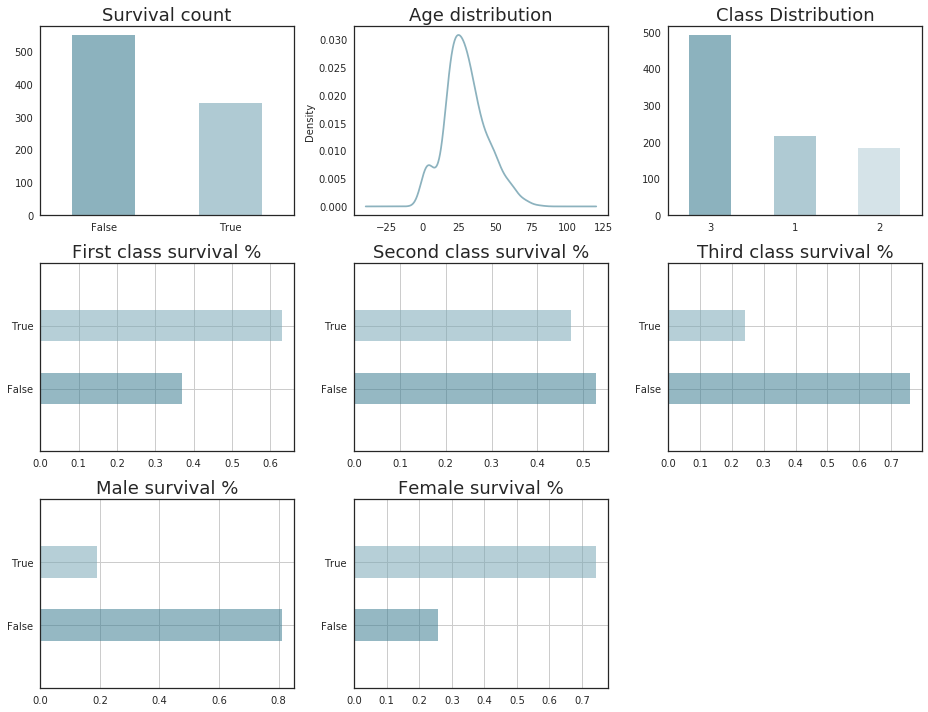

In [34]:
df["Pclass"]=pd.to_numeric(df["Pclass"])

# specifies the parameters of our graphs
fig=plt.figure(figsize=(13,10))


# plots a bar graph of those who surived vs those who did not.
ax1 = plt.subplot2grid((3,3), (0,0))
df.Survived.value_counts().plot(kind='bar', alpha=0.6, title="Survival count" ,rot=0)



# plots a bar graph of the age distribution
ax2 = plt.subplot2grid((3,3), (0,1))
df.Age.plot(kind='kde', alpha=0.6, title="Age distribution")


# plots a bar graph of the class distribution
ax3 = plt.subplot2grid((3,3),(0,2))
df.Pclass.value_counts().plot(kind="bar", alpha=0.6, title="Class Distribution",rot=0)

#count how many first/second/third class survived(1) vs died(0)
df_third_cl = df.Survived[df.Pclass == 3].value_counts().sort_index()
df_second_cl= df.Survived[df.Pclass == 2].value_counts().sort_index()
df_first_cl = df.Survived[df.Pclass == 1].value_counts().sort_index()

df

ax4 = plt.subplot2grid((3,3),(1,0))
(df_first_cl/df_first_cl.sum()).plot(kind='barh',label='First', alpha=0.55, grid=True)
plt.title("First class survival %")
ax4.set_ylim(-1, 2)

ax5 = plt.subplot2grid((3,3),(1,1))
(df_second_cl/df_second_cl.sum()).plot(kind='barh',label='Second', alpha=0.55, grid=True)
plt.title("Second class survival %")
ax5.set_ylim(-1, 2)

ax6 = plt.subplot2grid((3,3),(1,2))
(df_third_cl/df_third_cl.sum()).plot(kind='barh',label='Third', alpha=0.55, grid=True)
plt.title("Third class survival %")
ax6.set_ylim(-1, 2)


#Count males vs females
num_males = df[df.Sex =='male'].shape[0]
num_females = df[df.Sex =='female'].shape[0]

#count how many males/females survived(1) vs died(0)
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

#survival rate male vs female
male_surv_rate = df_male[1]/num_males
female_surv_rate = df_female[1]/num_females

#Male survival plot
ax7 = plt.subplot2grid((3,3),(2,0))
(df_male/df_male.sum()).plot(kind='barh',label='Male', alpha=0.55, grid=True)
plt.title("Male survival %")
ax7.set_ylim(-1, 2)
#Female survival plot
ax8 = plt.subplot2grid((3,3),(2,1))
(df_female/df_female.sum()).plot(kind='barh',label='Female', alpha=0.55, grid=True)
plt.title("Female survival %")
ax8.set_ylim(-1, 2)

plt.tight_layout()
plt.show()

# print("Males survived: {} vs died: {} -> rate : {}" .format(df_male[1],df_male[0],male_surv_rate))
# print("Females survived: {} vs died: {} -> rate: {}" .format(df_female[1],df_female[0],female_surv_rate))



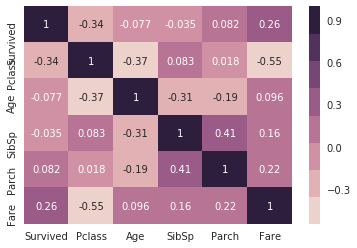

In [35]:
#Correlation between features
cov_matrix = df.corr(method="pearson")
sns.heatmap(cov_matrix,square=False,annot=True,cmap=sns.cubehelix_palette(8));